Copyright 2020 The Google Research Authors. All Rights Reserved.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**NOTE: Executing the code (training or evaluation) for the first time will download the full CLEVR dataset (17.7GB).**

In [ ]:
# Requirements: Python 3.x, TensorFlow 2.x, TensorFlow Datasets

from absl import logging
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# When executing this notebook out of a subfolder, use the command below to
# change to the project's root folder (required for imports):
# %cd ..

import slot_attention.data as data_utils
import slot_attention.model as model_utils

In [ ]:
# Hyperparameters.
seed = 0
batch_size = 1
num_slots = 7
num_iterations = 3
resolution = (128, 128)
ckpt_path = "/tmp/object_discovery/"  # Path to model checkpoint.

In [ ]:
def load_model(checkpoint_dir, num_slots=11, num_iters=3, batch_size=16):
  resolution = (128, 128)
  model = model_utils.build_model(
      resolution, batch_size, num_slots, num_iters,
      model_type="object_discovery")

  ckpt = tf.train.Checkpoint(network=model)
  ckpt_manager = tf.train.CheckpointManager(
      ckpt, directory=checkpoint_dir, max_to_keep=5)

  if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    logging.info("Restored from %s", ckpt_manager.latest_checkpoint)

  return model

In [ ]:
# Build dataset iterators, optimizers and model.
tf.random.set_seed(seed)
data_iterator = data_utils.build_clevr_iterator(
    batch_size, split="validation", resolution=resolution, shuffle=True,
    max_n_objects=6, get_properties=False, apply_crop=True)

model = load_model(ckpt_path, num_slots=num_slots, num_iters=num_iterations,
                   batch_size=batch_size)

In [ ]:
def renormalize(x):
  """Renormalize from [-1, 1] to [0, 1]."""
  return x / 2. + 0.5

def get_prediction(model, batch, idx=0):
  recon_combined, recons, masks, slots = model(batch["image"])
  image = renormalize(batch["image"])[idx]
  recon_combined = renormalize(recon_combined)[idx]
  recons = renormalize(recons)[idx]
  masks = masks[idx]
  return image, recon_combined, recons, masks, slots

In [ ]:
# Get new batch.
batch = next(data_iterator)

In [ ]:
# Predict.
image, recon_combined, recons, masks, slots = get_prediction(model, batch)

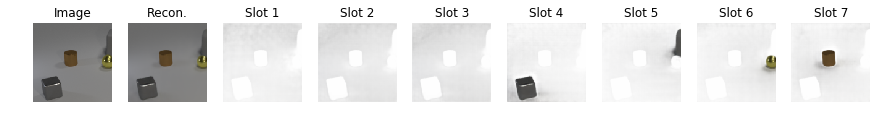

In [ ]:
# Visualize.
num_slots = len(masks)
fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[1].imshow(recon_combined)
ax[1].set_title('Recon.')
for i in range(num_slots):
  ax[i + 2].imshow(recons[i] * masks[i] + (1 - masks[i]))
  ax[i + 2].set_title('Slot %s' % str(i + 1))
for i in range(len(ax)):
  ax[i].grid(False)
  ax[i].axis('off')